<a href="https://colab.research.google.com/github/nprime496/experiments/blob/main/Malawi_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malawi News classification

* TODO
* classification_report
* words most used for classification for each category
* layer freeziing
* different learning rate
* top k error classification

## Introduction


## setup

In [92]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [93]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
!pip install transformers
!pip install datasets
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
import wandb
wandb.login()

wandb: Currently logged in as: nprime. Use `wandb login --relogin` to force relogin


True

In [12]:
%env WANDB_PROJECT=malawi_analysis


env: WANDB_PROJECT=malawi_analysis


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [14]:
import sklearn

import pandas as pd

In [15]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
base_dir="/content/drive/MyDrive/consistency/malawinews/"

In [8]:
import logging
# To control logging level for various modules used in the application:
import logging
import re
def set_global_logging_level(level=logging.ERROR, prefices=[""]):
    """
    Override logging levels of different modules based on their name as a prefix.
    It needs to be invoked after the modules have been loaded so that their loggers have been initialized.

    Args:
        - level: desired level. e.g. logging.INFO. Optional. Default is logging.ERROR
        - prefices: list of one or more str prefices to match (e.g. ["transformers", "torch"]). Optional.
          Default is `[""]` to match all active loggers.
          The match is a case-sensitive `module_name.startswith(prefix)`
    """
    prefix_re = re.compile(fr'^(?:{ "|".join(prefices) })')
    for name in logging.root.manager.loggerDict:
        if re.match(prefix_re, name):
            logging.getLogger(name).setLevel(level)
set_global_logging_level(logging.ERROR)

## Exploration

In [17]:
train=pd.read_csv(os.path.join(base_dir,"Train.csv"))

In [20]:
train.head()

,ID,Text,Label
0,ID_AASHwXxg,Mwangonde: Khansala wachinyamata Akamati achi...,POLITICS
1,ID_AGoFySzn,MCP siidakhutire ndi kalembera Chipani cha Ma...,POLITICS
2,ID_AGrrkBGP,Bungwe la MANEPO Lapempha Boma Liganizire Anth...,HEALTH
3,ID_AIJeigeG,Ndale zogawanitsa miyambo zanyanya Si zachile...,POLITICS
4,ID_APMprMbV,Nanga wapolisi ataphofomoka? Masiku ano sichi...,LAW/ORDER


In [21]:
test=pd.read_csv(os.path.join(base_dir,"Test.csv"))

In [22]:
label_to_int={label:key for key,label in enumerate(train.Label.unique())}
label_to_int

{'ARTS AND CRAFTS': 18,
 'CULTURE': 15,
 'ECONOMY': 11,
 'EDUCATION': 16,
 'FARMING': 4,
 'FLOODING': 19,
 'HEALTH': 1,
 'LAW/ORDER': 2,
 'LOCALCHIEFS': 9,
 'MUSIC': 17,
 'OPINION/ESSAY': 8,
 'POLITICS': 0,
 'RELATIONSHIPS': 13,
 'RELIGION': 3,
 'SOCIAL': 7,
 'SOCIAL ISSUES': 6,
 'SPORTS': 12,
 'TRANSPORT': 14,
 'WILDLIFE/ENVIRONMENT': 5,
 'WITCHCRAFT': 10}

In [106]:
int_to_label={label_to_int[label]:label for label in label_to_int.keys()}

In [107]:
train.Label.nunique()

20

In [108]:
LABELS = train.Label.unique()
LABELS

array(['POLITICS', 'HEALTH', 'LAW/ORDER', 'RELIGION', 'FARMING',
       'WILDLIFE/ENVIRONMENT', 'SOCIAL ISSUES', 'SOCIAL', 'OPINION/ESSAY',
       'LOCALCHIEFS', 'WITCHCRAFT', 'ECONOMY', 'SPORTS', 'RELATIONSHIPS',
       'TRANSPORT', 'CULTURE', 'EDUCATION', 'MUSIC', 'ARTS AND CRAFTS',
       'FLOODING'], dtype=object)

In [109]:
train.ID

0       ID_AASHwXxg
1       ID_AGoFySzn
2       ID_AGrrkBGP
3       ID_AIJeigeG
4       ID_APMprMbV
           ...     
1431    ID_zmTmmEio
1432    ID_znOlIaGQ
1433    ID_znracTjN
1434    ID_ztdsmmva
1435    ID_zteydTpN
Name: ID, Length: 1436, dtype: object

In [110]:
len(train)+len(test)

2056

In [111]:
train.columns

Index(['ID', 'Text', 'Label'], dtype='object')

In [112]:
train['nwords']=train.Text.apply(lambda x:len(x.split(' ')))

In [113]:
train.nwords

0       336
1       374
2       130
3       469
4        46
       ... 
1431    193
1432    528
1433    265
1434    355
1435    607
Name: nwords, Length: 1436, dtype: int64

In [114]:
train.groupby(['Label'])['nwords'].mean()

Label
ARTS AND CRAFTS         289.142857
CULTURE                 394.304348
ECONOMY                 358.488372
EDUCATION               274.627907
FARMING                 363.807692
FLOODING                351.571429
HEALTH                  249.921260
LAW/ORDER               282.301471
LOCALCHIEFS             425.920000
MUSIC                   310.200000
OPINION/ESSAY           412.730769
POLITICS                356.587814
RELATIONSHIPS           379.000000
RELIGION                196.190476
SOCIAL                  165.743421
SOCIAL ISSUES           351.320896
SPORTS                  269.408163
TRANSPORT               284.000000
WILDLIFE/ENVIRONMENT    251.305556
WITCHCRAFT              381.687500
Name: nwords, dtype: float64

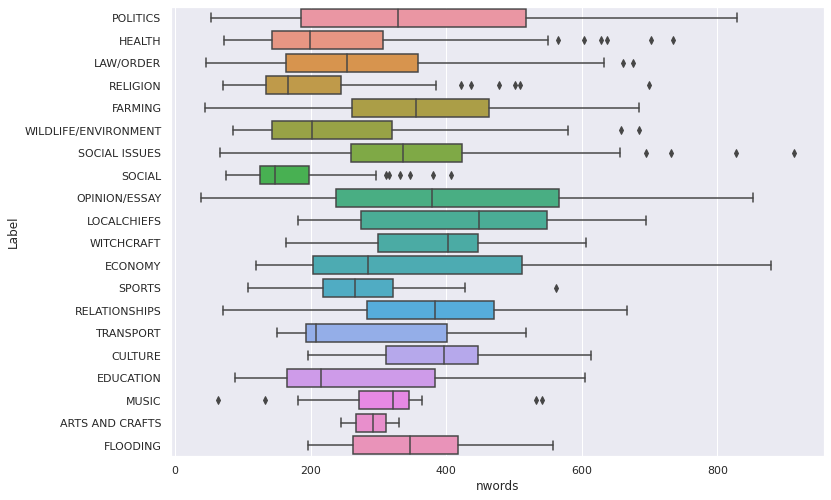

In [115]:
sns.boxplot(train['nwords'],y=train['Label'])

In [116]:
train.Text[0],train.Label[0]

(' Mwangonde: Khansala wachinyamata Akamati achinyamata ndi atsogoleri a mawa, ambiri amaganiza kuti izi ndi nkhambakamwa chabe. Koma achinyamata ena, monga Lusubilo Mwangonde, akukwaniritsa akupherezetsa mawuwa osati pongolota kuti adzakhala, koma kutsogolera kumene chifukwa nthawi yawo yakwana. DAILES BANDA adacheza ndi Mwangonde, khansala wachinyama, yemwe akuimira Jumbo Ward mumzinda wa Mzuzu, motere:  Chisale watuluka nkumangidwanso  Sipakala waimitsa Nyumba ya Malamulo  Pa Wenela pasintha zedi Ali ndi masomphenya: Mwangonde Tikudziweni  Ndine Lusubilo Mwangonde, ndili ndi zaka 27 zakubadwa. Ndinabadwa mbanja la ana asanu ndipo ndine wachinayi kubadwa. Ndimachokera mmudzi mwa Mwamalopa, kwa Paramount Chief Kyungu mboma la Karonga. Sindili pabanja pakadalipano.\n Mbiri ya maphunziro anu ndi yotani? Maphunziro anga a pulaimale ndidachitira kusukula yapulaiveti ya Viphya mumzinda wa Mzuzu ndipo asekondale ndidachitira pa Phwezi Boys mboma la Rumphi. Ndili ndi diploma ya Accounting nd

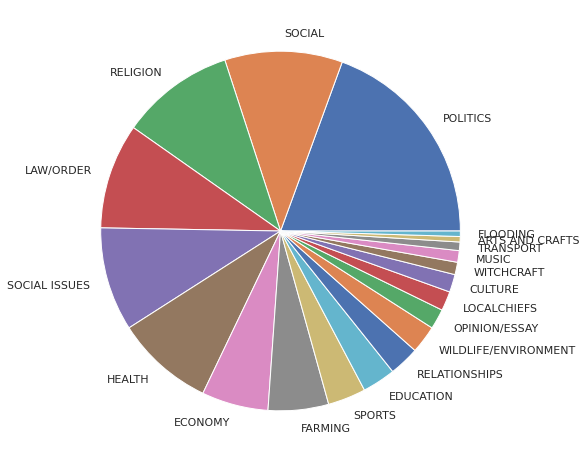

In [117]:
counts=train.Label.value_counts()
plt.pie(counts.values,labels=counts.index)
plt.show()

In [118]:
train['len']=train.Text.apply(lambda x: len(x.split(" ")))

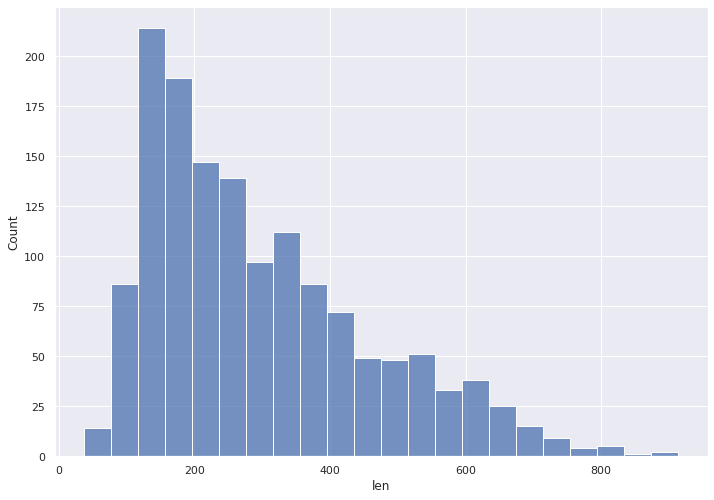

In [119]:
sns.histplot(train.len)

In [120]:
def show_example(data,theme, n_examples=10):
  sub=data[data.Label.apply(lambda x: x.lower())==theme.lower()]
  if len(sub)<n_examples:
    return sub.Text.values
  return sub.sample(n_examples).Text.values
  

In [121]:
show_example(train,'CULTURE')

array([' Mafumu akhumudwa ndi kuvula amayi Mafumu komanso anthu mdziko muno ati ndiokhumudwa ndi zomwe oganiziridwa kuti ndi mavenda mmizinda wa Lilongwe, Blantyre ndi Mzuzu msabatayi povula mbulanda amayi omwe adavala mabuluku kapena siketi zazifupi.\n  Chisale watuluka nkumangidwanso  Sipakala waimitsa Nyumba ya Malamulo  Chakwera akwanitse malonjezoHRDC Ndemangazi zati apolisi afufuze ndi kugwira omwe adachita chipongwechi.\n Malipoti osatsimikizika ochokera ku Mzuzu Lachitatu amati kumenekonso ena adavula amayi ena kumalo okwerera basi ndipo pomwe nthawi imakwana 12 koloko nkuti apolisi ali balala.\n Mafumuwa ati apolisi sakuyenera kunyengerera ndipo yemwe agwidwe akuyenera kukalandira chilango.\n T/A Kaomba ya mboma la Kasungu idati ngati munthu sadavale moyenera ndibwino kuwauza ena amudzudzule, osati kumuvula.\n Zandikwiyitsa. Ngati sadavale bwino akadapeza amayi ena kuti akawadzudzule; uku nkuchititsa manyazi dziko, adatero Kaomba.\n Senior Chief Tengani ya mboma la Nsanje yati

## cleaning

In [29]:
# from data set
from collections import Counter
import regex as re
  
data_set = ". ".join(train.Text)
# split() returns list of all the words in the string


In [30]:
pattern = r'\b[0-9]*'
train.Text=train.Text.apply(lambda x:x.lower()) # lowercase
train.Text=train.Text.apply(lambda x:x.replace("\n", "")) # remove break line
train.Text=train.Text.apply(lambda x:re.sub(pattern, '', x)) # Match all digits in the string and replace them by empty string

In [31]:
split_it = data_set.split()
  
# Pass the split_it list to instance of Counter class.
counter = Counter(split_it)
  
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = counter.most_common(30)
  
stopwords_chichewa = {el for el,_ in most_occur}- {'.'}

stopwords_chichewa 

{'a',
 'adatero',
 'adati',
 'amene',
 'anthu',
 'boma',
 'cha',
 'chifukwa',
 'dziko',
 'ena',
 'koma',
 'komanso',
 'ku',
 'kuti',
 'kwa',
 'la',
 'mu',
 'mwa',
 'ndi',
 'ndipo',
 'ngati',
 'ntchito',
 'omwe',
 'pa',
 'wa',
 'wati',
 'ya',
 'za',
 'zomwe'}

In [32]:
train.Text = train.Text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_chichewa)]))

In [33]:
train.Text

0       mwangonde: khansala wachinyamata akamati achin...
1       mcp siidakhutire kalembera chipani malawi cong...
2       bungwe manepo lapempha liganizire achikulire m...
3       ndale zogawanitsa miyambo zanyanya si zachilen...
4       nanga wapolisi ataphofomoka? masiku ano sichik...
                              ...                        
1431    eni minibus ati ali ufulu wokweza mitengo mmod...
1432    kachali apepesa: kulankhula motumbwa kuthe ant...
1433    mawu supports non-fiction writers the malawi w...
1434    tame mwawa: phwete ndiye kudya kwake sewero ti...
1435    pac iunguza chifedulo nthumwi zimakumana mumzi...
Name: Text, Length: 1436, dtype: object

In [127]:
def reduce(text,head,tail):
  l=text.split(" ")
  if len(l)<(head+tail):
    return text
  m=l[:head]+l[len(l)-tail:]
  assert(len(m)==(head+tail)),f"error {len(m)}!={head+tail}"
  s=" ".join(m)
  return s


In [128]:
train.Text=train.Text.apply(lambda x:reduce(x,100,300))

In [129]:
s=train.Text.apply(lambda x:len(x.split(" ")))

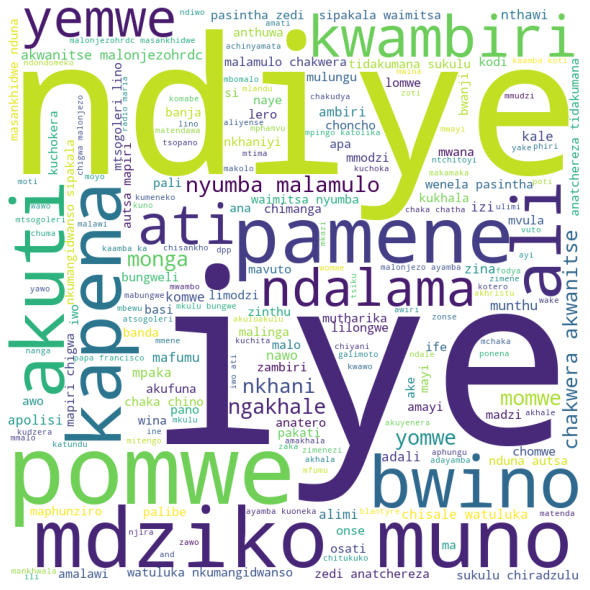

In [130]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd


comment_words = ''

stopwords = stopwords_chichewa

# iterate through the csv file
for val in train.Text:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


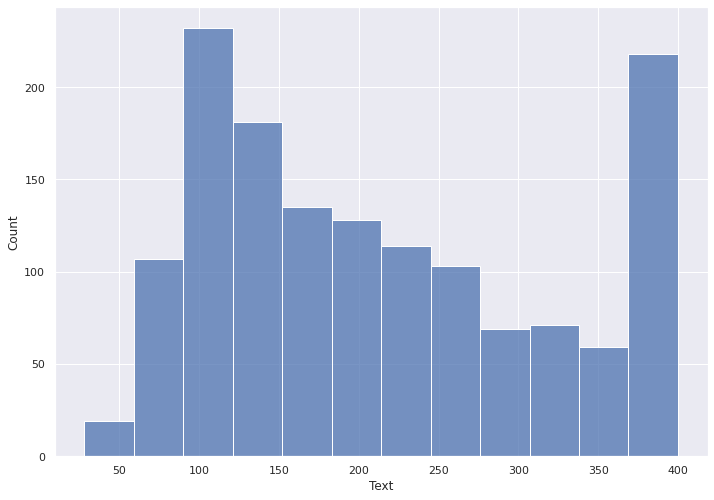

In [131]:
sns.histplot(s)

In [132]:
import torch

class MalawiDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

        if self.labels is not None:
          item["labels"] = torch.tensor(label_to_int[self.labels[idx]])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

## model1


In [133]:
from sklearn.model_selection import train_test_split


X_train,X_test= train_test_split(train[['Text','Label']],stratify=train['Label'])
X_train,X_eval= train_test_split(X_train,stratify=X_train['Label'])

In [134]:
X_train

,Text,Label
846,papa alimbikitsa sukulu ukachenjede katolika m...,EDUCATION
465,chilima adzapikitsana nawo chaka mawa wachiwir...,POLITICS
357,malawi lili kuthekera kochita zinthu palokha c...,ECONOMY
1382,nice trust ilimbikitsa bata pambuyo chigamulo ...,POLITICS
995,"mcp, utm asainira mgwirizano kudali khwimbi ka...",POLITICS
...,...,...
1247,kanengo parish yayimitsa maulendo onse kunyanj...,HEALTH
430,mudalinji mchakachi? ma alubino aona zakuda mp...,POLITICS
1073,ana ofunika pobwezeretsa chilengedwe-bt archdi...,WILDLIFE/ENVIRONMENT
1335,mnyamata asiya sukulu mantha makhumbira atakha...,EDUCATION


In [135]:
MODELS={
    "bert-base-multilingual-uncased",
    #"bert-base-uncased"
}

In [136]:
MODEL_NAME="bert-base-uncased"

In [137]:
for m in MODELS:
  print(m)

bert-base-multilingual-uncased


In [138]:

# config = dict (
#   learning_rate = 0.01,
#   momentum = 0.2,
#   architecture = "CNN",
#   dataset_id = "peds-0192",
#   infra = "AWS",
# )

# wandb.init(
#   project="malawi_analysis",
#   notes="tweak baseline",
#   tags=["baseline", "paper1"],
#   config=config,
# )

In [139]:
help(sklearn.utils.class_weight.compute_class_weight)

Help on function compute_class_weight in module sklearn.utils.class_weight:

compute_class_weight(class_weight, *, classes, y)
    Estimate class weights for unbalanced datasets.
    
    Parameters
    ----------
    class_weight : dict, 'balanced' or None
        If 'balanced', class weights will be given by
        ``n_samples / (n_classes * np.bincount(y))``.
        If a dictionary is given, keys are classes and values
        are corresponding class weights.
        If None is given, the class weights will be uniform.
    
    classes : ndarray
        Array of the classes occurring in the data, as given by
        ``np.unique(y_org)`` with ``y_org`` the original class labels.
    
    y : array-like of shape (n_samples,)
        Array of original class labels per sample.
    
    Returns
    -------
    class_weight_vect : ndarray of shape (n_classes,)
        Array with class_weight_vect[i] the weight for i-th class.
    
    References
    ----------
    The "balanced" heurist

In [140]:
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced',classes=LABELS,y=X_train.Label)

In [141]:
LABELS

array(['POLITICS', 'HEALTH', 'LAW/ORDER', 'RELIGION', 'FARMING',
       'WILDLIFE/ENVIRONMENT', 'SOCIAL ISSUES', 'SOCIAL', 'OPINION/ESSAY',
       'LOCALCHIEFS', 'WITCHCRAFT', 'ECONOMY', 'SPORTS', 'RELATIONSHIPS',
       'TRANSPORT', 'CULTURE', 'EDUCATION', 'MUSIC', 'ARTS AND CRAFTS',
       'FLOODING'], dtype=object)

In [142]:
class_weights

array([ 0.25700637,  0.56830986,  0.53092105,  0.49207317,  0.91704545,
        2.0175    ,  0.53092105,  0.47470588,  2.69      ,  2.88214286,
        4.48333333,  0.82346939,  1.44107143,  1.83409091,  6.725     ,
        3.10384615,  1.68125   ,  5.04375   , 10.0875    , 10.0875    ])

In [143]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def __init__(self,weights=None,**kwargs):
      super(CustomTrainer,self).__init__(**kwargs)
      self.weights=torch.tensor(weights).to(self.args.device).float()

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [144]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification,EarlyStoppingCallback,AutoConfig
import numpy as np

from sklearn.metrics import f1_score

from transformers import TrainingArguments


def tokenize_data(tokenizer,example):
    return tokenizer(example, padding='max_length',truncation=True)

train_mode=False

if train_mode:
  for MODEL_NAME in MODELS:

      tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

      train_encodings = tokenize_data(tokenizer,X_train.Text.to_list())
      eval_encodings = tokenize_data(tokenizer,X_eval.Text.to_list())
      test_encodings = tokenize_data(tokenizer,X_test.Text.to_list())


      train_dataset = MalawiDataset(train_encodings, X_train.Label.values)
      val_dataset = MalawiDataset(eval_encodings, X_eval.Label.values)
      test_dataset = MalawiDataset(test_encodings, X_test.Label.values)
      


      config = AutoConfig.from_pretrained(MODEL_NAME)

      config.id2label = int_to_label
      config.label2id = label_to_int

      model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,config=config)

      # # freeze bert layers
      # for param in model.bert.parameters():
      #     param.requires_grad = False

      training_args = TrainingArguments(f"trainer_weighted_head_{MODEL_NAME}",        learning_rate=1e-5,
      eval_steps = 20, # Evaluation and Save happens every 20 steps
        evaluation_strategy ='steps',logging_steps=1,save_strategy='steps',num_train_epochs=8,load_best_model_at_end = True,report_to="wandb")
        
      trainer = CustomTrainer(
      model=model, args=training_args, train_dataset=train_dataset, eval_dataset=val_dataset,

          callbacks = [EarlyStoppingCallback(early_stopping_patience=3)],weights=class_weights
          )
      trainer.train()

      trainer.save_model(os.path.join(base_dir,"best_model"))

      eval_pred=trainer.predict(val_dataset)

      logits,labels,_=eval_pred
      predictions = np.argmax(logits, axis=-1)

      score=f1_score(val_dataset.labels,[int_to_label[pred] for pred in predictions],average='weighted')

      print(f"f1-score weighted for model {MODEL_NAME} is {score}")
      wandb.finish()


In [145]:
def predict_proba(trainer,tokenizer):
  def predict(texts):
    encodings = tokenize_data(tokenizer,texts)
    dataset = MalawiDataset(encodings, None)
    logits,_,_=trainer.predict(dataset)
    return logits
  return predict


In [146]:
# loading best model

#model = AutoModelForSequenceClassification.from_pretrained(os.path.join(base_dir,"best_model"))

In [147]:
# creating pipeline for simple classification
from transformers import pipeline

#tokenizer = AutoTokenizer.from_pretrained(list(MODELS)[0])
#classifier = pipeline("text-classification", model=model,tokenizer=tokenizer,max_length=512, truncation=True)

In [148]:
# trainer=Trainer(model=model)
# logits,labels,_=trainer.predict(test_dataset)

## Model2

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")

In [35]:
wn = WordNetLemmatizer()
def text_preprocessing(review):
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = review.lower()
    review = review.split()
    review = [wn.lemmatize(word) for word in review if not word in stopwords_chichewa]
    review = ' '.join(review)
    return review

In [36]:
train_data=pd.DataFrame(train)
test_data= pd.DataFrame(test)

In [37]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [38]:
train_data['Text'] = train['Text'].apply(text_preprocessing)
test_data['Text'] = train['Text'].apply(text_preprocessing)
print(train_data.head())
print(test_data.head())

            ID                                               Text      Label
0  ID_AASHwXxg  mwangonde khansala wachinyamata akamati achiny...   POLITICS
1  ID_AGoFySzn  mcp siidakhutire kalembera chipani malawi cong...   POLITICS
2  ID_AGrrkBGP  bungwe manepo lapempha liganizire achikulire m...     HEALTH
3  ID_AIJeigeG  ndale zogawanitsa miyambo zanyanya si zachilen...   POLITICS
4  ID_APMprMbV  nanga wapolisi ataphofomoka masiku ano sichikh...  LAW/ORDER
            ID                                               Text
0  ID_ADHEtjTi  mwangonde khansala wachinyamata akamati achiny...
1  ID_AHfJktdQ  mcp siidakhutire kalembera chipani malawi cong...
2  ID_AUJIHpZr  bungwe manepo lapempha liganizire achikulire m...
3  ID_AUKYBbIM  ndale zogawanitsa miyambo zanyanya si zachilen...
4  ID_AZnsVPEi  nanga wapolisi ataphofomoka masiku ano sichikh...


In [39]:
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(train_data['Text']).toarray()
training = pd.DataFrame(X, columns=vectorizer.get_feature_names())
print(training.shape)
X_test_final = vectorizer.transform(test_data['Text']).toarray()
test_new = pd.DataFrame(X_test_final, columns=vectorizer.get_feature_names())
print(test_new.shape)

(1436, 10000)
(620, 10000)


In [60]:

# with open(os.path.join(base_dir,"sgdclassifier","vectorizer"),'wb') as file:
#  pickle.dump(vectorizer,file)


In [40]:
X = training
y = train_data['Label']

In [41]:
label_encoder = LabelEncoder()
y_label = label_encoder.fit_transform(y)

In [42]:
smote = SMOTE()
X, y_label = smote.fit_resample(X,y_label)
np.bincount(y_label)

array([279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279, 279,
       279, 279, 279, 279, 279, 279, 279])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.1, random_state=0)

In [44]:
import numpy as np
from sklearn.decomposition import PCA
import pickle



In [45]:
# pca = PCA(n_components=1000)
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

In [46]:

# with open(os.path.join(base_dir,"sgdclassifier","pca"),'wb') as file:
#  pickle.dump(pca,file)


In [52]:
with open(os.path.join(base_dir,"sgdclassifier","pca"),'rb') as f:
  pca = pickle.load(f)

In [47]:
# means = pca.means_   #put this into a .npy file

In [48]:
# from sklearn.utils.extmath import safe_sparse_dot
# td = test_data - means
# tdd = safe_sparse_dot(td, pca.components_.T)

In [53]:
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

In [54]:
base_dir

'/content/drive/MyDrive/consistency/malawinews/'

In [55]:
sum(pca.explained_variance_ratio_)

#print(pca.singular_values_)

0.9570099644094485

In [56]:
model = SGDClassifier(loss='hinge', 
                      alpha=4e-4, 
                      max_iter=20, 
                      verbose=False)
model.fit(X_train_pca, y_train)

SGDClassifier(alpha=0.0004, max_iter=20, verbose=False)

In [59]:

# with open(os.path.join(base_dir,"sgdclassifier","model"),'wb') as file:
#  pickle.dump(model,file)


In [57]:
pred = model.predict(X_test_pca)
print("Train Accuracy Score:",round(model.score(X_train_pca, y_train),2))
print("Test Accuracy Score:",round(accuracy_score(y_test, pred),2))

Train Accuracy Score: 0.98
Test Accuracy Score: 0.93


In [58]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        25
           2       0.91      0.72      0.81        29
           3       0.92      1.00      0.96        22
           4       0.97      1.00      0.98        29
           5       1.00      1.00      1.00        29
           6       0.90      0.93      0.92        30
           7       0.87      0.90      0.89        30
           8       0.91      1.00      0.95        20
           9       1.00      1.00      1.00        37
          10       1.00      1.00      1.00        25
          11       0.78      0.75      0.77        24
          12       1.00      1.00      1.00        31
          13       0.67      0.88      0.76        25
          14       0.94      0.55      0.70        29
          15       0.85      0.89      0.87        19
          16       1.00      1.00      1.00        30
          17       0.94    

In [169]:
def predict_sgd(texts):
  tfidf_version = vectorizer.transform(texts)
  pca_version = pca.transform(tfidf_version.toarray())
  return model.predict(pca_version)[0]

## evaluation

In [170]:
# specify the classifier to use

classifier = predict_sgd

In [171]:
import numpy as np
from datasets import load_metric
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels,_ = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

#trainer.evaluate()

In [172]:
#f1_score(val_dataset.labels,[int_to_label[pred] for pred in predictions],average='weighted')

In [173]:
# pred_labels = [int_to_label[pred] for pred in np.argmax(logits,axis=-1)]
# confusion_matrix = metrics.confusion_matrix(test_dataset.labels,pred_labels,labels=LABELS)
# print(confusion_matrix)

In [ ]:
pred_labels = classifier(X_test)
confusion_matrix = metrics.confusion_matrix(label_encoder.transform(test_dataset.labels),pred_labels,labels=LABELS)
print(confusion_matrix)

In [ ]:
disp=ConfusionMatrixDisplay(confusion_matrix,display_labels=[int_to_label[i][:3] for i in range(20)])
disp.plot()

In [ ]:
LABELS

In [ ]:
import numpy as np
from sklearn.metrics import top_k_accuracy_score,accuracy_score

print(accuracy_score(test_dataset.labels,pred_labels))


In [ ]:
# Not normalizing gives the number of "correctly" classified samples
print(top_k_accuracy_score([label_to_int[l] for l in test_dataset.labels], logits, k=3))

## Explanation

In [ ]:
classifier([X_eval.Text.iloc[197]])

In [ ]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=LABELS)

In [ ]:
X_eval[X_eval.Label=="MUSIC"]

In [ ]:
%%time
idx = 1197
sample_text = train.Text[idx]
sample_label = train.Label[idx]


In [ ]:
true_label = label_encoder.transform([sample_label])[0]
predicted_label = classifier([sample_text])

In [ ]:
label_encoder.classes_

In [ ]:
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
le_name_mapping

In [ ]:
true_label

In [ ]:
%%time
# Training explainer (WARNING: It may take a while)

exp = explainer.explain_instance(sample_text, classifier , num_features=6, labels=list(set([predicted_label,true_label])))

In [ ]:
print('Document id: %d' % idx)
print('Predicted class =', int_to_label[predicted_label])
print('True class: %s' % sample_label)

In [ ]:
print ('Explanation for class %s' % LABELS[predicted_label])
print ('\n'.join(map(str, exp.as_list(label=predicted_label))))


In [ ]:
print ()
print ('Explanation for class %s' % LABELS[true_label])
print ('\n'.join(map(str, exp.as_list(label=true_label))))

In [ ]:
exp.show_in_notebook(text=False)

In [ ]:
exp.show_in_notebook(text=sample_text, labels=(predicted_label,true_label))

## Comments


## Conclusion